# Introduction to GeoPandas

This quick tutorial introduces the key concepts and basic feautures of GeoPandas to help you get started with your projects.

## Concepts

GeoPandas, as the name suggests, extends the popular data science library [pandas](https://pandas.pydata.org) by adding support for geospatial data. If you are not familiar with `pandas`, we recommend taking a quick look at its [Getting started documentation](https://pandas.pydata.org/docs/getting_started/index.html#getting-started) before proceeding.

The core data structure in GeoPandas is the `geopandas.GeoDataFrame`, a subclass of `pandas.DataFrame`, that can store geometry columns and perform spatial operations. The `geopandas.GeoSeries`, a subclass of `pandas.Series`, handles the geometries. Therefore, your `GeoDataFrame` is a combination of `pandas.Series`, with traditional data (numerical, boolean, text etc.), and `geopandas.GeoSeries`, with geometries (points, polygons etc.). You can have as many columns with geometries as you wish; there's no limit typical for desktop GIS software.

![geodataframe schema](../_static/dataframe.svg)

Each `GeoSeries` can contain any geometry type (you can even mix them within a single array) and has a `GeoSeries.crs` attribute, which stores information about the projection (CRS stands for Coordinate Reference System). Therefore, each `GeoSeries` in a `GeoDataFrame` can be in a different projection, allowing you to have, for example, multiple versions (different projections) of the same geometry.

Only one `GeoSeries` in a `GeoDataFrame` is considered the _active_ geometry, which means that all geometric operations applied to a `GeoDataFrame` operate on this _active_ column.


<div class="alert alert-info">
User Guide
    
See more on [data structures in the User Guide](../docs/user_guide/data_structures.rst).
</div>


Let's see how some of these concepts work in practice.

## Reading and writing files

First, we need to read some data.

### Reading files

Assuming you have a file containing both data and geometry (e.g. GeoPackage, GeoJSON, Shapefile), you can read it using `geopandas.read_file()`, which automatically detects the filetype and creates a `GeoDataFrame`. This tutorial uses the `"nybb"` dataset, a map of New York boroughs, which is part of the GeoPandas installation. Therefore, we use `geopandas.datasets.get_path()` to retrieve the path to the dataset.

In [1]:
import geopandas

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

### Writing files

To write a `GeoDataFrame` back to file use `GeoDataFrame.to_file()`. The default file format is Shapefile, but you can specify your own with the `driver` keyword.

In [2]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

<div class="alert alert-info">
User Guide
    
See more on [reading and writing data in the User Guide](../docs/user_guide/io.rst).
</div>



## Simple accessors and methods

Now we have our `GeoDataFrame` and can start working with its geometry. 

Since there was only one geometry column in the New York Boroughs dataset, this column automatically becomes the _active_ geometry and spatial methods used on the `GeoDataFrame` will be applied to the `"geometry"` column.

### Measuring area

To measure the area of each polygon (or MultiPolygon in this specific case), access the `GeoDataFrame.area` attribute, which returns a `pandas.Series`. Note that `GeoDataFrame.area` is just `GeoSeries.area` applied to the _active_ geometry column.

But first, to make the results easier to read, set the names of the boroughs as the index:

In [3]:
gdf = gdf.set_index("BoroName")

In [4]:
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

### Getting polygon boundary and centroid

To get the boundary of each polygon (LineString), access the `GeoDataFrame.boundary`:

In [5]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

Since we have saved boundary as a new column, we now have two geometry columns in the same `GeoDataFrame`.

We can also create new geometries, which could be, for example, a buffered version of the original one (i.e., `GeoDataFrame.buffer(10)`) or its centroid:

In [6]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

BoroName
Staten Island     POINT (941639.450 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx            POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

### Measuring distance

We can also measure how far each centroid is from the first centroid location.

In [7]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

Note that `geopandas.GeoDataFrame` is a subclass of `pandas.DataFrame`, so we have all the pandas functionality available to use on the geospatial dataset — we can even perform data manipulations with the attributes and geometry information together.

For example, to calculate the average of the distances measured above, access the 'distance' column and call the mean() method on it:

In [8]:
gdf['distance'].mean()

76140.09102166798

In [9]:
gdf

BoroCode     Shape_Leng    Shape_Area  \
BoroName                                               
Staten Island         5  330470.010332  1.623820e+09   
Queens                4  896344.047763  3.045213e+09   
Brooklyn              3  741080.523166  1.937479e+09   
Manhattan             1  359299.096471  6.364715e+08   
Bronx                 2  464392.991824  1.186925e+09   

                                                        geometry  \
BoroName                                                           
Staten Island  MULTIPOLYGON (((970217.022 145643.332, 970227....   
Queens         MULTIPOLYGON (((1029606.077 156073.814, 102957...   
Brooklyn       MULTIPOLYGON (((1021176.479 151374.797, 102100...   
Manhattan      MULTIPOLYGON (((981219.056 188655.316, 980940....   
Bronx          MULTIPOLYGON (((1012821.806 229228.265, 101278...   

                       area  \
BoroName                      
Staten Island  1.623822e+09   
Queens         3.045214e+09   
Brooklyn       1.937478e+09   
Manhattan      6.364712e+08   
Bronx          1.186926e+09   

                                                        boundary  \
BoroName                                                           
Staten Island  MULTILINESTRING ((970217.022 145643.332, 97022...   
Queens         MULTILINESTRING ((1029606.077 156073.814, 1029...   
Brooklyn       MULTILINESTRING ((1021176.479 151374.797, 1021...   
Manhattan      MULTILINESTRING ((981219.056 188655.316, 98094...   
Bronx          MULTILINESTRING ((1012821.806 229228.265, 1012...   

                                     centroid       distance  
BoroName                                                      
Staten Island   POINT (941639.450 150931.991)       0.000000  
Queens         POINT (1034578.078 197116.604)  103781.535276  
Brooklyn        POINT (998769.115 174169.761)   61674.893421  
Manhattan       POINT (993336.965 222451.437)   88247.742789  
Bronx          POINT (1021174.790 249937.980)  126996.283623

## Making maps

GeoPandas can also plot maps, so we can check how the geometries appear in space. To plot the active geometry, call `GeoDataFrame.plot()`. To color code by another column, pass in that column as the first argument. In the example below, we plot the active geometry column and color code by the `"area"` column. We also want to show a legend (`legend=True`).

<AxesSubplot:>

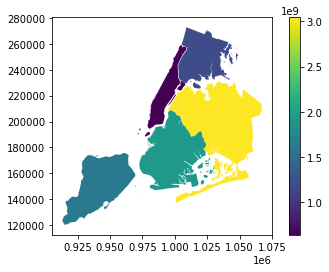

In [10]:
gdf.plot("area", legend=True)

You can also explore your data interactively using `GeoDataFrame.explore()`, which behaves in the same way `plot()` does but returns an interactive map instead.

In [11]:
gdf.explore("area", legend=False)

Switching the active geometry (`GeoDataFrame.set_geometry`) to centroids, we can plot the same data using point geometry.

In [ ]:
gdf = gdf.set_geometry("centroid")
gdf.plot("area", legend=True)

And we can also layer both `GeoSeries` on top of each other. We just need to use one plot as an axis for the other.

In [ ]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")

Now we set the active geometry back to the original `GeoSeries`.

In [ ]:
gdf = gdf.set_geometry("geometry")

<div class="alert alert-info">
User Guide
    
See more on [mapping in the User Guide](../docs/user_guide/mapping.rst).
</div>

## Geometry creation

We can further work with the geometry and create new shapes based on those we already have. 

### Convex hull

If we are interested in the convex hull of our polygons, we can access `GeoDataFrame.convex_hull`.

In [ ]:
gdf["convex_hull"] = gdf.convex_hull

In [ ]:
ax = gdf["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

### Buffer

In other cases, we may need to buffer the geometry using `GeoDataFrame.buffer()`. Geometry methods are automatically applied to the active geometry, but we can apply them directly to any `GeoSeries` as well. Let's buffer the boroughs and their centroids and plot both on top of each other.

In [ ]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)
gdf["buffered"] = gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)
gdf["buffered_centroid"] = gdf["centroid"].buffer(10000)

In [ ]:
ax = gdf["buffered"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=.5)  # passing the first plot as an axis to the second
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

<div class="alert alert-info">
User Guide
    
See more on [geometry creation and manipulation in the User Guide](../docs/user_guide/geometric_manipulations.rst).
</div>

## Geometry relations

We can also ask about the spatial relations of different geometries. Using the geometries above, we can check which of the buffered boroughs intersect the original geometry of Brooklyn, i.e., is within 10 000 feet from Brooklyn.

First, we get a polygon of Brooklyn.

In [ ]:
brooklyn = gdf.loc["Brooklyn", "geometry"]
brooklyn

The polygon is a [shapely geometry object](https://shapely.readthedocs.io/en/stable/manual.html#geometric-objects), as any other geometry used in GeoPandas.

In [ ]:
type(brooklyn)

Then we can check which of the geometries in `gdf["buffered"]` intersects it.

In [ ]:
gdf["buffered"].intersects(brooklyn)

Only Bronx (on the north) is more than 10 000 feet away from Brooklyn. All the others are closer and intersect our polygon.

Alternatively, we can check which buffered centroids are entirely within the original boroughs polygons. In this case, both `GeoSeries` are aligned, and the check is performed for each row.

In [ ]:
gdf["within"] = gdf["buffered_centroid"].within(gdf)
gdf["within"]

We can plot the results on the map to confirm the finding.

In [ ]:
gdf = gdf.set_geometry("buffered_centroid")
ax = gdf.plot("within", legend=True, categorical=True, legend_kwds={'loc': "upper left"})  # using categorical plot and setting the position of the legend
gdf["boundary"].plot(ax=ax, color="black", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

## Projections

Each `GeoSeries` has its Coordinate Reference System (CRS) accessible at `GeoSeries.crs`. The CRS tells GeoPandas where the coordinates of the geometries are located on the earth's surface. In some cases, the CRS is geographic, which means that the coordinates are in latitude and longitude. In those cases, its CRS is WGS84, with the authority code `EPSG:4326`. Let's see the projection of our NY boroughs `GeoDataFrame`.

In [ ]:
gdf.crs

Geometries are in `EPSG:2263` with coordinates in feet. We can easily re-project a `GeoSeries` to another CRS, like `EPSG:4326` using `GeoSeries.to_crs()`.

In [ ]:
gdf = gdf.set_geometry("geometry")
boroughs_4326 = gdf.to_crs("EPSG:4326")
boroughs_4326.plot()

In [ ]:
boroughs_4326.crs

Notice the difference in coordinates along the axes of the plot. Where we had 120 000 - 280 000 (feet) before, we now have 40.5 - 40.9 (degrees). In this case, `boroughs_4326` has a `"geometry"` column in WGS84 but all the other (with centroids etc.) remain in the original CRS.

<div class="alert alert-warning">
Warning
    
For operations that rely on distance or area, you always need to use a projected CRS (in meters, feet, kilometers etc.) not a geographic one (in degrees). GeoPandas operations are planar, whereas degrees reflect the position on a sphere. Therefore, spatial operations using degrees may not yield correct results. For example, the result of `gdf.area.sum()` (projected CRS) is 8 429 911 572 ft<sup>2</sup> but the result of `boroughs_4326.area.sum()` (geographic CRS) is 0.083.
</div>

<div class="alert alert-info">
User Guide
    
See more on [projections in the User Guide](../docs/user_guide/projections.rst).
</div>

## What next?

With GeoPandas we can do much more than what has been introduced so far, from [aggregations](../docs/user_guide/aggregation_with_dissolve.rst), to [spatial joins](../docs/user_guide/mergingdata.rst), to [geocoding](../docs/user_guide/geocoding.rst), and [much more](../gallery/index.rst).

Head over to the [User Guide](../docs/user_guide.rst) to learn more about the different features of GeoPandas, the [Examples](../gallery/index.rst) to see how they can be used, or to the [API reference](../docs/reference.rst) for the details.